In [ ]:
import pandas as pd 
import numpy as np 
import re
import tensorflow as tf
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Model,Sequential
from tensorflow.keras.layers import Dropout,Dense,Flatten,Embedding,LSTM
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer

In [ ]:
movie_reviews = pd.read_csv("/content/drive/MyDrive/ML Projects/Text Analysis/IMDB Dataset.csv")
movie_reviews.shape

(50000, 2)

In [ ]:
def preprocess_text(sen):
    sentence = remove_tags(sen)
    sentence = re.sub('[^a-zA-Z]',' ',sentence)
    sentence = re.sub(r"\s+[a-zA-Z]\s+",' ',sentence)
    sentence = re.sub(r'\s+',' ',sentence)
    return sentence

TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('',text)

In [ ]:
X = []
sentences = list(movie_reviews['review'])
for sen in sentences:
    X.append(preprocess_text(sen))

Y = movie_reviews['sentiment']
Y = np.array(list(map(lambda x : 1 if x=='positive' else 0,Y)))

In [ ]:
X_train, X_test , Y_train , Y_test = train_test_split(X,Y,test_size = 0.15)

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

type(X_train)

list

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2021-09-23 05:02:01--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-09-23 05:02:01--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-09-23 05:02:02--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [ ]:
import os
path_to_glove_file = os.path.join(os.path.expanduser("~"), "/content/glove.6B.300d.txt")

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))


Found 400000 word vectors.


In [ ]:
vocab_size = len(tokenizer.word_index)+1
word_index = tokenizer.word_index
X_train = pad_sequences(X_train,padding = 'pre',maxlen = 300)
X_test = pad_sequences(X_test,padding = 'pre',maxlen = 300)

In [ ]:
num_tokens = vocab_size + 1
embedding_dim = 300
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

embedding_layer = Embedding(num_tokens,embedding_dim,embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),trainable=False)

Converted 71291 words (23696 misses)


In [ ]:
inputs = tf.keras.Input(shape=(None,))
X = embedding_layer(inputs)
X = tf.keras.layers.LSTM(200,return_sequences=True)(X)
X = tf.keras.layers.LSTM(200,return_sequences=True)(X)
#X = tf.keras.layers.LSTM(200,return_sequences=True)(X)
X = tf.keras.layers.LSTM(200)(X)
X = Dense(1,activation = 'sigmoid')(X)
model = Model(inputs=inputs,outputs=X)
'''
model = Sequential()
model.add(embedding_layer)
model.add(LSTM(200,return_sequences=True,dropout=0.3))
model.add(LSTM(200,return_sequences=True,dropout=0.3))
model.add(LSTM(200,return_sequences=False,dropout=0.3))
model.add(Dense(1,activation ='sigmoid'))
'''

"\nmodel = Sequential()\nmodel.add(embedding_layer)\nmodel.add(LSTM(200,return_sequences=True,dropout=0.3))\nmodel.add(LSTM(200,return_sequences=True,dropout=0.3))\nmodel.add(LSTM(200,return_sequences=False,dropout=0.3))\nmodel.add(Dense(1,activation ='sigmoid'))\n"

In [ ]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding_1 (Embedding)      (None, None, 300)         28496700  
_________________________________________________________________
lstm_4 (LSTM)                (None, None, 200)         400800    
_________________________________________________________________
lstm_5 (LSTM)                (None, None, 200)         320800    
_________________________________________________________________
lstm_6 (LSTM)                (None, 200)               320800    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 201       
Total params: 29,539,301
Trainable params: 1,042,601
Non-trainable params: 28,496,700
_______________________________________

In [ ]:
#X_train=np.array(X_train)
#Y_train = np.array(Y_train)
len(X_train[0])

300

In [ ]:
history = model.fit(X_train,Y_train,batch_size=32,epochs=10)

Epoch 1/10
1329/1329 [==============================] - 278s 209ms/step - loss: 0.0174 - accuracy: 0.9942
Epoch 2/10
1329/1329 [==============================] - 276s 208ms/step - loss: 0.0152 - accuracy: 0.9949
Epoch 3/10
1329/1329 [==============================] - 277s 208ms/step - loss: 0.0145 - accuracy: 0.9957
Epoch 4/10
1329/1329 [==============================] - 278s 209ms/step - loss: 0.0200 - accuracy: 0.9942
Epoch 5/10
1329/1329 [==============================] - 278s 209ms/step - loss: 0.0162 - accuracy: 0.9948
Epoch 6/10
1329/1329 [==============================] - 278s 209ms/step - loss: 0.0164 - accuracy: 0.9943
Epoch 7/10
1329/1329 [==============================] - 278s 209ms/step - loss: 0.0132 - accuracy: 0.9957
Epoch 8/10
1329/1329 [==============================] - 278s 209ms/step - loss: 0.0183 - accuracy: 0.9941
Epoch 9/10
1329/1329 [==============================] - 278s 209ms/step - loss: 0.0117 - accuracy: 0.9962
Epoch 10/10
1329/1329 [=======================

In [ ]:
model.evaluate(X_test,Y_test)

235/235 [==============================] - 24s 102ms/step - loss: 0.8252 - accuracy: 0.8572


[0.8252442479133606, 0.857200026512146]

In [ ]:
tf.keras.models.save_model(model,"/content/drive/MyDrive/Text Analysis /")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Text Analysis /assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Text Analysis /assets


In [ ]:
import pickle

# saving
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
model = tf.keras.models.load_model("/content/drive/MyDrive/Text Analysis /")
    

In [ ]:
import pickle
with open("/content/drive/MyDrive/Text Analysis /tokenizer.pickle", 'rb') as handle:
    tokenizer = pickle.load(handle)

In [ ]:
text = str(input("Enter comment : "))
text = preprocess_text(text)
text = [text.split(" ")]
text = tokenizer.texts_to_sequences(text)
text = pad_sequences(text)
prediction=model.predict(text)
value = prediction[0][0]
print("\nSigmoid output value : ",value)
prediction = prediction<0.5
if prediction[0][0]==True:
    print("\nPredicted sentiment of the comment : Negative Comment")
else:
    print("\nPredicted sentiment of the comment : Positive Comment")

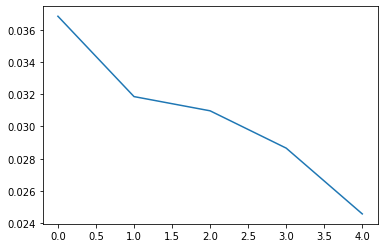

In [ ]:
import matplotlib.pyplot as plt

loss = history.history['loss']
plt.plot(loss)

In [ ]:
pickle.dump(model,open("model.pkl",'wb'))

AttributeError: ignored

In [ ]:
!kaggle competitions download -c twitter-sentiment-analysis2

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python2.7/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python2.7/dist-packages/kaggle/api/kaggle_api_extended.py", line 146, in authenticate
    self.config_file, self.config_dir))
IOError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.
